# Project Objective:
    
     * To predict which of the Policies are likely to incur a Claim based on past Claims History
        
# Contents of the Notebook:

     * Data Cleaning, Pre-processing and Exploratory Data Analysis to understand the Overall picture, influence of Each factor  

# Data Scope and Assumptions:
    
    1. Data Duration: 2010 - 2014
    2. Level of Data: Policy - Each record in the data represents a unique policy.
                      All metrics including Gross Premium, Number of Employees, Claim Frequency, 
                      Net Incurred Claim Cost etc. are calculated for each policy
    3.Calculations:
                    Policy Count = number of records corresponding to each cohort of data
                    Premium = sum of Gross Written Premium Excl PI
                    Claim Count = sum of claim counts associted withe ach policy
                    Claim Incurred = sum of claim incurred associated with each policy
    4.Assumptions:
            
            1. Each record represents a unique policy
            2. Whenever a policy gets renewed, they are treated as a nfresh new policy as Underwriting is performed 
               at the time of Policy Renewal
                       
    5.Data Challenges and Resolution:
            
            1. There are multiple fields with same name, but with different entries for a specific record
            2. Duplicates are present at the overall data. Duplicate records are removed
            3. Very less data is present for 2010,2011, and 2012. 2013 and 2014 contribute the maximum
            4. PolicyCancellationDate field has no values poluated through out the data. Hence the column is dropped
            5. ALl other fields have a good fill rate
            
    6.Key Findings from the EDA:
        
            1. Overall:
                *Even though the number of Claims received in 2011 and 2014 ae more than their respective previous years,
                 there is a drop for Claim Incurred Cost for both these years
            2. Business Type:
                *Even though the number of Claims lodged by Renewal business is almost half the claims loged by 
                *New Business,the Incurred Cost for Renewal Business stands very low compared to the Incurred Cost 
                 for New Business
            3. Public Liability Limit:
                *Policies with 2M Limit brings the maximum number of Claims followed by 1M, 5M and 10M.
                *However, CLaim Incurred Cost is highest for policies with 5M limit, followed by 2M, 1M and 10M
            4. Employers Liability Limit:
                *Policies with 0 Employers Liability limit is the highest in terms of Volume
                *However, in terms of premium policies with 10M imit contributes the highest 
                *Claim Incurred Cost is highest for Policies with 10M limit
            5. Professional Indemnity Limit:
                *For policies with 1M Professional Indemnity, has a relatively higher Policy Volume
                *However, for policies with 2M have a higher Claim Incurred Cost
            6. Trade Category:
                *Negligle number of claims are received for Arts & Crafts, and Catering Categories
                *Even though the number of Claims received are higher for Professional, Incurred Cost for the same is 
                 very less
                *Net Incurred Cost is highest for Building/Allied, followed by Mech/Allied, Cleaning and Decline categories
                
## Next Steps:

            1. Performing Trend analysis for each of the factor:
                    * Understand how each factor changes its behaviour across different years
                    * Identify underlying seasonalities, fluctuations of feature values over time etc.
                
            2. Perform Multi Factor Comparison:
                    * Understand how a specific feature or feature value behaviour is influcenced by other features
                    * Identify whether any kind of correlation exists between different factors
                    * Identify the effect of time, or how a feature's behaviour changes with previous time period


In [ ]:
# Import Necessary Libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from matplotlib.pyplot import pie, axis, show

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import plotly.plotly as py
import plotly.graph_objs as go

# Import the required data files from excel

policy_data = pd.read_csv('policy_data.csv')

In [22]:
# View the imported policy data to have a quick glimpse of Fields and Field Values

policy_data.head()

Unnamed: 0    Source_System             Product  Underwriting_Year  \
0           0  Simply Business  Maltings Tradesman               2014   
1           1  Simply Business  Maltings Tradesman               2014   
2           2  Simply Business  Maltings Tradesman               2014   
3           3  Simply Business  Maltings Tradesman               2014   
4           4  Simply Business  Maltings Tradesman               2014   

     Effective_Date       Expiry_Date Transaction_Type  \
0  19/09/2014 01:00  18/09/2015 01:00     New Business   
1    8/10/2014 1:00    7/10/2015 1:00     New Business   
2  18/09/2014 01:00  17/09/2015 01:00     New Business   
3    3/10/2014 1:00    2/10/2015 1:00     New Business   
4  20/09/2014 01:00  19/09/2015 01:00     New Business   

   Public_Liability_Limit  Employers_Liability_Limit  Tools_Sum_Insured  \
0                 1000000                          0                0.0   
1                 5000000                          0                0.0   
2                 5000000                   10000000             4000.0   
3                 2000000                          0             2000.0   
4                 1000000                          0                0.0   

          ...                      Location  Public_Liability_Limit_5000000.2  \
0         ...                      BRIGHTON                                 0   
1         ...                       BRISTOL                                 1   
2         ...                   NORTHAMPTON                                 1   
3         ...                     CAMBRIDGE                                 0   
4         ...           NEWCASTLE UPON TYNE                                 0   

   Public_Liability_Limit_5000000.3  Professional_Indemnity_Limit_g  \
0                                 0                               1   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               1   

  Risk_Postcode2 TotalEmployees  Claim_Count  Claim_Incurred  \
0         BN21 3              1            0             0.0   
1         BS15 4              1            0             0.0   
2         NN10 8              8            0             0.0   
3          CB8 7             10            0             0.0   
4          NE5 1              1            0             0.0   

   Capped_Incurred_50k Capped_Incurred_100k  
0                  0.0                  0.0  
1                  0.0                  0.0  
2                  0.0                  0.0  
3                  0.0                  0.0  
4                  0.0                  0.0  

[5 rows x 68 columns]

In [23]:
# Understand the dimensions of the data

print('Number of records, features in the data:',policy_data.shape)

Number of records, features in the data: (232962, 68)


** Check for Duplicate Records in the Overall Data **

In [24]:
# Check for duplicates and drop duplicate records

# Drop the first column as it contains the rownumber, because of which dulictons will be ignored
policy_data_wo_dup = policy_data.drop('Unnamed: 0',axis=1)

# Remove duplicates at Oerall Level
policy_data_wo_dup.drop_duplicates()

# Get the number of Records and Features in the New Data
policy_data_wo_dup.shape

(232962, 67)

In [25]:
# Understand the datatypes, fill rate for each feature in the input data

print('Features, number of non-null records, data type')
print('-----------------------------------------------------------------------------------')
policy_data_wo_dup.info()

Features, number of non-null records, data type
-----------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232962 entries, 0 to 232961
Data columns (total 67 columns):
Source_System                       232962 non-null object
Product                             232962 non-null object
Underwriting_Year                   232962 non-null int64
Effective_Date                      232962 non-null object
Expiry_Date                         232962 non-null object
Transaction_Type                    232962 non-null object
Public_Liability_Limit              232962 non-null int64
Employers_Liability_Limit           232962 non-null int64
Tools_Sum_Insured                   232962 non-null float64
Professional_Indemnity_Limit        232962 non-null int64
Contract_Works_Sum_Insured          232962 non-null int64
Hired_in_Plan_Sum_Insured           232962 non-null int64
Own_Plant_Sum_Insured               232962 non-null in

## Data Inconsistencies and Resolution:

After going through the data, certain data inconsistencies are identified as follows:

1. There are derived fields created by encoding the values of 'Public_Liability_Limit' field. The inconsistency is that,
   there are multiple fields with same name However they contain different values for the same policy

2. Similar issue is observed with 'Professional_Indemnity_Limit' field as well

Suggested resolution is to drop these inconsistent fields before the data processing. 

Fresh encoding will be performed after data processing and before the modelling


In [26]:
# Drop the redundant features

policy_data_wo_dup_1 = policy_data_wo_dup.drop( ['Public_Liability_Limit_1000000',
                   'Public_Liability_Limit_1000000.1',
                   'Public_Liability_Limit_2000000',
                   'Public_Liability_Limit_5000000',
                    'Public_Liability_Limit_5000000.1',
                    'Public_Liability_Limit_1000000.2',
                    'Public_Liability_Limit_1000000.3',
                    'Employers_Liability_Limit_1000',
                    'Professional_Indemnity_Limit_5',
                    'Professional_Indemnity_Limit_5.1',
                    'Professional_Indemnity_Limit_1',
                    'Professional_Indemnity_Limit_1.1',
                    'Professional_Indemnity_Limit_2',
                    'Professional_Indemnity_Limit_2.1',
                    'Professional_Indemnity_Limit_5.2',
                    'Professional_Indemnity_Limit_5.3',
                    'Professional_Indemnity_Limit_1.2',
                    'Professional_Indemnity_Limit_1.3',
                    'Professional_Indemnity_Limit_2.2',
                    'Professional_Indemnity_Limit_2.3',
                    'Public_Liability_Limit_5000000.2',
                    'Public_Liability_Limit_5000000.3' 
                  ], axis = 1)

policy_data_wo_dup_1.columns

Index(['Source_System', 'Product', 'Underwriting_Year', 'Effective_Date',
       'Expiry_Date', 'Transaction_Type', 'Public_Liability_Limit',
       'Employers_Liability_Limit', 'Tools_Sum_Insured',
       'Professional_Indemnity_Limit', 'Contract_Works_Sum_Insured',
       'Hired_in_Plan_Sum_Insured', 'Own_Plant_Sum_Insured', 'Trade_1',
       'Trade_2', 'Manual_EE', 'Clerical_EE', 'Subcontractor_EE', 'Match_Type',
       'Trade_1_Category', 'Trade_2_Category', 'Trade_1_Risk_Level',
       'Trade_2_Risk_Level', 'Effective_Date2', 'CancellationEffectiveDate',
       'Total_Gross_Premium_excl_IPT', 'Commission_Amount',
       'Net_Premium_to_UW', 'Policy_Count', 'Gross_Premium_Excl_PI',
       'Gross_PI_Premium', 'DurationofPolicy', 'CombinedTradeRiskLevel',
       'Tools_Sum_Insured_Ind', 'Contract_Works_Sum_Insured_Ind',
       'Hired_in_Plan_Sum_Insured_Ind', 'Own_Plant_Sum_Insured_Ind',
       'Location', 'Professional_Indemnity_Limit_g', 'Risk_Postcode2',
       'TotalEmployees', '

In [27]:
# Check and Remove Duplicate Records

policy_data_wo_dup_2 = policy_data_wo_dup_1.drop_duplicates()

policy_data_wo_dup_2.shape

(232716, 45)

After removing the duplicate Features and Records, identify the number of Claims dropped

In [28]:
policy_data_wo_dup.Claim_Count.value_counts()

0    229689
1      3098
2       150
3        22
4         3
Name: Claim_Count, dtype: int64

In [29]:
policy_data_wo_dup_2.Claim_Count.value_counts()

0    229444
1      3097
2       150
3        22
4         3
Name: Claim_Count, dtype: int64

** Record for 1 Claim is dropped after removing redundant features and records **

In [30]:
# Check for number of missing records in each feature

print(policy_data_wo_dup_2.isnull().sum())

Source_System                          0
Product                                0
Underwriting_Year                      0
Effective_Date                         0
Expiry_Date                            0
Transaction_Type                       0
Public_Liability_Limit                 0
Employers_Liability_Limit              0
Tools_Sum_Insured                      0
Professional_Indemnity_Limit           0
Contract_Works_Sum_Insured             0
Hired_in_Plan_Sum_Insured              0
Own_Plant_Sum_Insured                  0
Trade_1                                0
Trade_2                            25133
Manual_EE                              0
Clerical_EE                            0
Subcontractor_EE                       0
Match_Type                             0
Trade_1_Category                       0
Trade_2_Category                       0
Trade_1_Risk_Level                     0
Trade_2_Risk_Level                     0
Effective_Date2                        0
CancellationEffe

 **Value for CancellationEffectiveDate for all records is NULL - DROP THE FIELD**

 **11% of Trade2, 0.2% of Location have NULL values**

 **For all other fields, the fill rate is 100%**

In [31]:
# Drop the irrelevant Fields - CancellationEffectiveDate

policy_data_2 = policy_data_wo_dup_2.drop(['CancellationEffectiveDate'], axis=1)

# Check whether the field is dropped

policy_data_2.head()

policy_data_2.shape

(232716, 44)

In [32]:
# Understand the Basic Statistics for each feature in the data

policy_data_2.describe()

Underwriting_Year  Public_Liability_Limit  Employers_Liability_Limit  \
count      232716.000000            2.327160e+05               2.327160e+05   
mean         2013.350290            2.484234e+06               2.796542e+06   
std             0.793234            2.028191e+06               4.488302e+06   
min          2010.000000            1.000000e+06               0.000000e+00   
25%          2013.000000            1.000000e+06               0.000000e+00   
50%          2013.000000            2.000000e+06               0.000000e+00   
75%          2014.000000            5.000000e+06               1.000000e+07   
max          2014.000000            1.000000e+07               1.000000e+07   

       Tools_Sum_Insured  Professional_Indemnity_Limit  \
count      232716.000000                  2.327160e+05   
mean          358.221034                  1.738288e+05   
std          1209.842269                  4.244325e+05   
min             0.000000                  0.000000e+00   
25%             0.000000                  0.000000e+00   
50%             0.000000                  0.000000e+00   
75%             0.000000                  5.000000e+04   
max         30000.000000                  2.000000e+06   

       Contract_Works_Sum_Insured  Hired_in_Plan_Sum_Insured  \
count               232716.000000              232716.000000   
mean                  3645.236829                 809.280728   
std                  32280.437320                7056.852380   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                1000000.000000              250000.000000   

       Own_Plant_Sum_Insured      Manual_EE    Clerical_EE  \
count          232716.000000  232716.000000  232716.000000   
mean              242.414441       1.147575       1.175381   
std              3216.453695       1.321838       2.451347   
min                 0.000000       0.000000       0.000000   
25%                 0.000000       1.000000       0.000000   
50%                 0.000000       1.000000       0.000000   
75%                 0.000000       1.000000       0.000000   
max            500000.000000      42.000000      27.000000   

               ...           Tools_Sum_Insured_Ind  \
count          ...                   232716.000000   
mean           ...                        0.124976   
std            ...                        0.330693   
min            ...                        0.000000   
25%            ...                        0.000000   
50%            ...                        0.000000   
75%            ...                        0.000000   
max            ...                        1.000000   

       Contract_Works_Sum_Insured_Ind  Hired_in_Plan_Sum_Insured_Ind  \
count                   232716.000000                  232716.000000   
mean                         0.023518                       0.018155   
std                          0.151542                       0.133513   
min                          0.000000                       0.000000   
25%                          0.000000                       0.000000   
50%                          0.000000                       0.000000   
75%                          0.000000                       0.000000   
max                          1.000000                       1.000000   

       Own_Plant_Sum_Insured_Ind  Professional_Indemnity_Limit_g  \
count              232716.000000                   232716.000000   
mean                    0.016733                        0.250413   
std                     0.128269                        0.433252   
min                     0.000000                        0.000000   
25%                     0.000000                        0.000000   
50%                     0.000000                        0.000000   
75%                     

### Exploratory Data Analysis Begins

* Unerstand the distrbuion of polcies across claim volumes

In [33]:
# Check the distribution of claims

policy_data_2.Claim_Count.value_counts()

0    229444
1      3097
2       150
3        22
4         3
Name: Claim_Count, dtype: int64

 98.6% policies don't have any claims associated with them

 1.4% policies ony have associated claims

In [34]:
# Understand the Claim Incurred Cost Distribution

policy_data_2.groupby(['Claim_Count'])[['Claim_Incurred']].sum()

Claim_Incurred
Claim_Count                
0                      0.00
1               21437030.98
2                3872560.03
3                1300751.79
4                   7406.60

Understand the Year on Year Trend for Policy Count, GWP, Claim Count and Incurred Cost

In [35]:
agg_year = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year'])[['Policy_Count']].sum())
agg_year['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year'])[['Claim_Count']].sum())
agg_year['Prem'] = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year'])[['Gross_Premium_Excl_PI']].sum())
agg_year['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year'])[['Claim_Incurred']].sum())

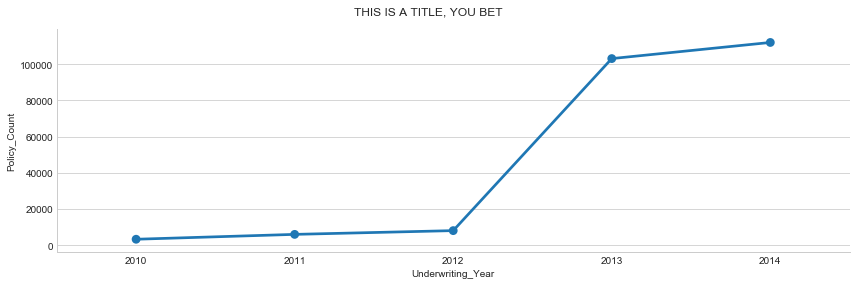

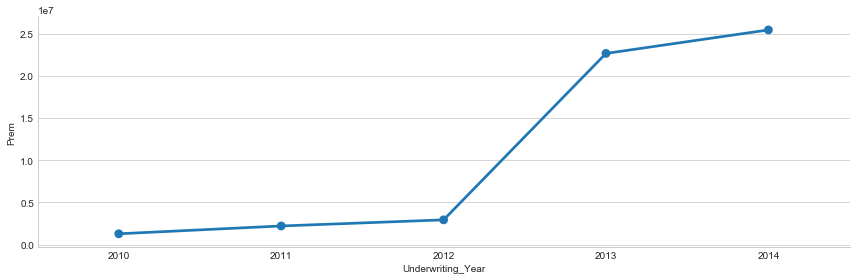

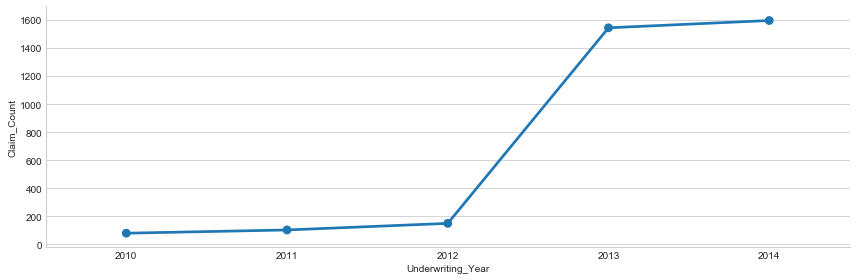

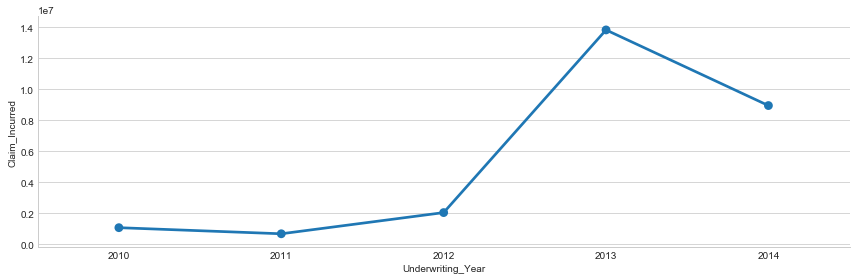

In [118]:
agg_year['Underwriting_Year'] = agg_year.index

g = sns.factorplot('Underwriting_Year','Policy_Count', 
               data=agg_year,
               gsize=4,aspect=3, 
               legend=True, 
               legend_out=True,
               alpha=0.7, size=4)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('THIS IS A TITLE, YOU BET')

sns.factorplot('Underwriting_Year','Prem', 
               data=agg_year,
               gsize=4,aspect=3, 
               legend=True, 
               legend_out=True,
               alpha=0.7, size=4)

sns.factorplot('Underwriting_Year','Claim_Count', 
               data=agg_year,
               gsize=4,aspect=3, 
               legend=True, 
               legend_out=True,
               alpha=0.7, size=4)

sns.factorplot('Underwriting_Year','Claim_Incurred', 
               data=agg_year,
               gsize=4,aspect=3, 
               legend=True, 
               legend_out=True,
               alpha=0.7, size=4)

** Inference from the Trend Analysis:  **
    
    1. There is an increasing trend of business both in terms of Volume and Premium
    2. There is an unusual spike in 2013 compared to 2012
    3. Even though the number of Claims received in 2011 and 2014 ae more than their respective previous years,
       there is a drop for Claim Incurred Cost for both these years

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across different products**

In [37]:
# Aggregation

agg_prod = pd.DataFrame(policy_data_2.groupby(['Product'])[['Policy_Count']].sum())
agg_prod['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Product'])[['Claim_Count']].sum())
agg_prod['Prem'] = pd.DataFrame(policy_data_2.groupby(['Product'])[['Gross_Premium_Excl_PI']].sum())
agg_prod['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Product'])[['Claim_Incurred']].sum())

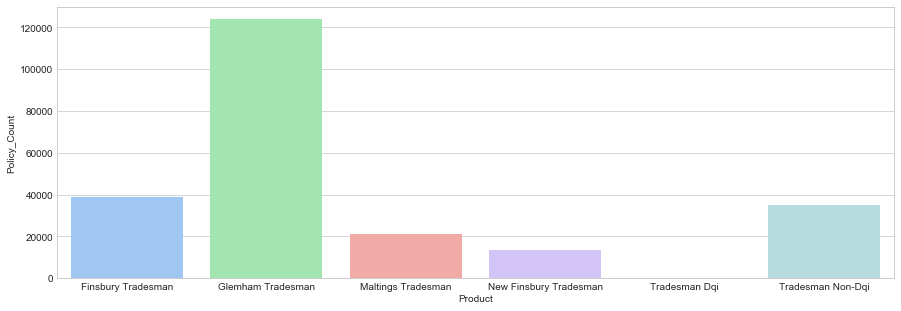

In [38]:
# Chart creation

agg_prod['Product'] = agg_prod.index

a4_dims = (15, 5)# Define the chart dimension
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Product', y='Policy_Count',palette= 'pastel', 
             data=agg_prod)

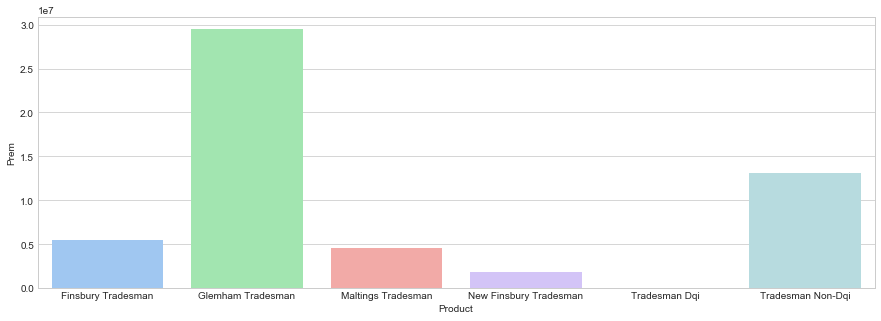

In [39]:
agg_prod['Product'] = agg_prod.index

a4_dims = (15, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Product', y='Prem',palette= 'pastel', 
             data=agg_prod)

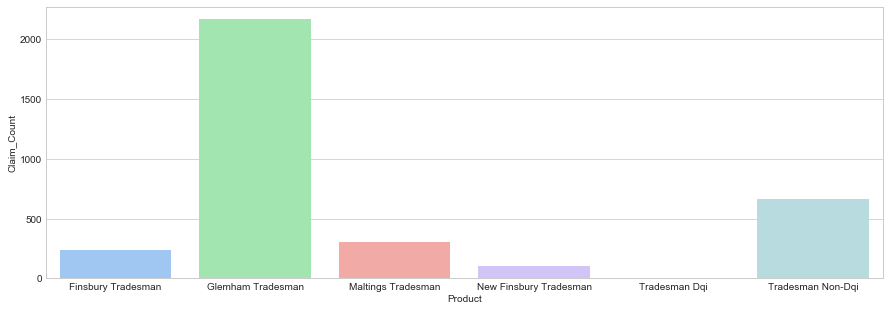

In [40]:
agg_prod['Product'] = agg_prod.index

a4_dims = (15, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Product', y='Claim_Count',palette= 'pastel', 
             data=agg_prod)

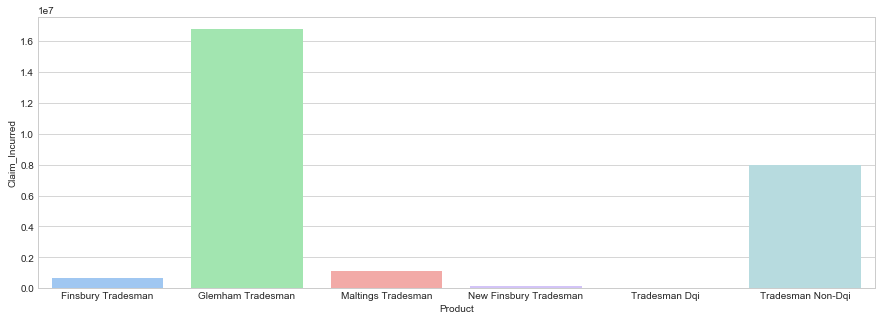

In [41]:
agg_prod['Product'] = agg_prod.index

a4_dims = (15, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Product', y='Claim_Incurred',palette= 'pastel', 
             data=agg_prod)

In [ ]:
** Inference from the Products:  **
    
    1. There is an increasing trend of business both in terms of Volume and Premium
    2. There is an unusual spike in 2013 compared to 2012
    3. Even though the number of Claims received in 2011 and 2014 ae more than their respective previous years,
       there is a drop for Claim Incurred Cost for both these years

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across different Transaction Types **

In [42]:
agg_ttyp = pd.DataFrame(policy_data_2.groupby(['Transaction_Type'])[['Policy_Count']].sum())
agg_ttyp['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Transaction_Type'])[['Claim_Count']].sum())
agg_ttyp['Prem'] = pd.DataFrame(policy_data_2.groupby(['Transaction_Type'])[['Gross_Premium_Excl_PI']].sum())
agg_ttyp['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Transaction_Type'])[['Claim_Incurred']].sum())

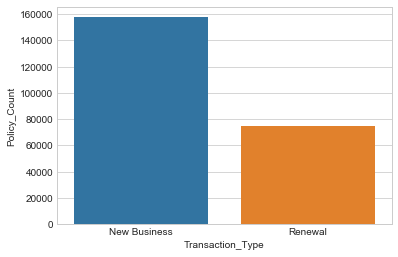

In [43]:
agg_ttyp['Transaction_Type'] = agg_ttyp.index

sns.barplot(x='Transaction_Type', y='Policy_Count', 
             data=agg_ttyp)

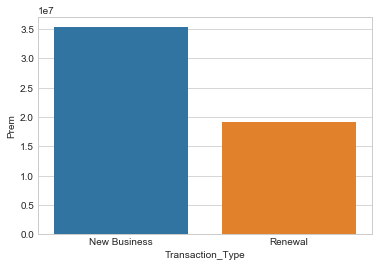

In [44]:
sns.barplot(x='Transaction_Type', y='Prem', 
             data=agg_ttyp)

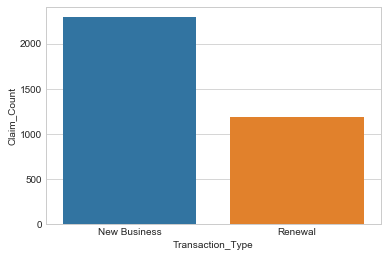

In [45]:
sns.barplot(x='Transaction_Type', y='Claim_Count', 
             data=agg_ttyp)

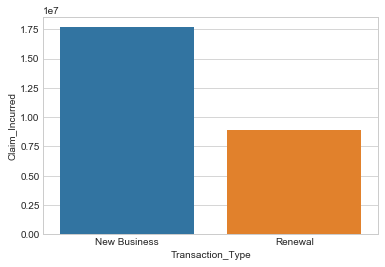

In [46]:
sns.barplot(x='Transaction_Type', y='Claim_Incurred', 
             data=agg_ttyp)

** Inference from Transaction Type Analysis **

    1. New Business contributes almost double the contribution on Renewal Business in terms of both Volume and Premium
    2. Even though the number of Claims lodged by Renewal business is almost half the claims loged by New Business,
       the Incurred Cost for Renewal Business stands very low compared to the Incurred Cost for New Business

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Public Liability Limit **

In [47]:
agg_pbll = pd.DataFrame(policy_data_2.groupby(['Public_Liability_Limit'])[['Policy_Count']].sum())
agg_pbll['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Public_Liability_Limit'])[['Claim_Count']].sum())
agg_pbll['Prem'] = pd.DataFrame(policy_data_2.groupby(['Public_Liability_Limit'])[['Gross_Premium_Excl_PI']].sum())
agg_pbll['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Public_Liability_Limit'])[['Claim_Incurred']].sum())

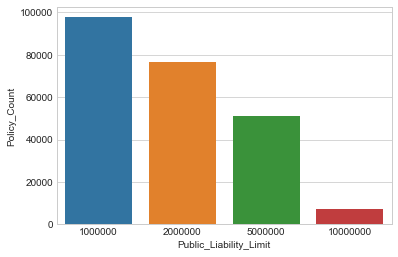

In [48]:
agg_pbll['Public_Liability_Limit'] = agg_pbll.index

sns.barplot(x='Public_Liability_Limit', y='Policy_Count', 
             data=agg_pbll)

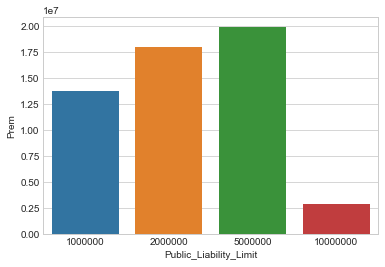

In [49]:
sns.barplot(x='Public_Liability_Limit', y='Prem', 
             data=agg_pbll)

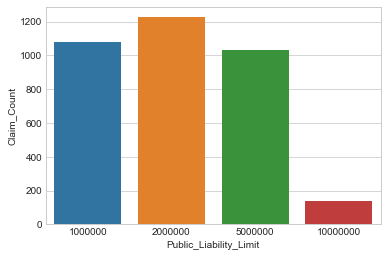

In [50]:
sns.barplot(x='Public_Liability_Limit', y='Claim_Count', 
             data=agg_pbll)

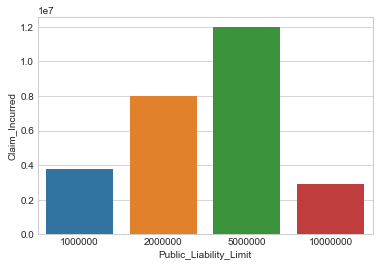

In [51]:
sns.barplot(x='Public_Liability_Limit', y='Claim_Incurred', 
             data=agg_pbll)

** Inference from Public Liability Analysis **

    1. In terms of Policy Volume, pilicies with liability limit 1M has the highest contribution followed by 2M, 5M and 10M
    2. However, in terms of premium policies with 5M limit contributes the highest followed by 2M, 1M and 10M. 
    3. Premium Contribution % of 10M limit policies is almost double the Volume Contribution % of the same category
    4. Policies with 2M Limit brings the maximum number of Claims followed by 1M, 5M and 10M
    5. However, CLaim Incurred Cost is highest for policies with 5M limit, followed by 2M, 1M and 10M

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Employers Liability Limit **

In [52]:
agg_emll = pd.DataFrame(policy_data_2.groupby(['Employers_Liability_Limit'])[['Policy_Count']].sum())
agg_emll['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Employers_Liability_Limit'])[['Claim_Count']].sum())
agg_emll['Prem'] = pd.DataFrame(policy_data_2.groupby(['Employers_Liability_Limit'])[['Gross_Premium_Excl_PI']].sum())
agg_emll['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Employers_Liability_Limit'])[['Claim_Incurred']].sum())

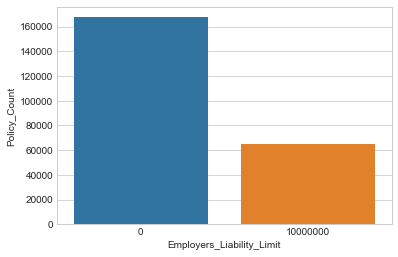

In [53]:
agg_emll['Employers_Liability_Limit'] = agg_emll.index

sns.barplot(x='Employers_Liability_Limit', y='Policy_Count', 
             data=agg_emll)

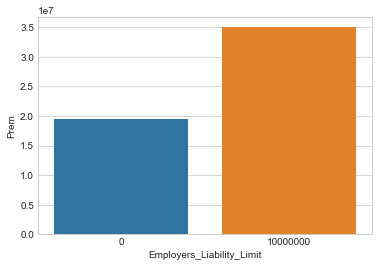

In [54]:
sns.barplot(x='Employers_Liability_Limit', y='Prem', 
             data=agg_emll)

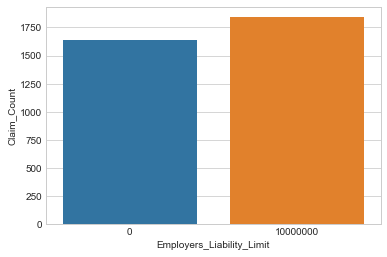

In [55]:
sns.barplot(x='Employers_Liability_Limit', y='Claim_Count', 
             data=agg_emll)

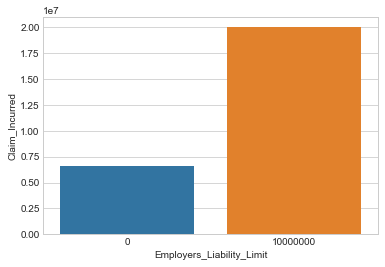

In [56]:
sns.barplot(x='Employers_Liability_Limit', y='Claim_Incurred',
             data=agg_emll)

** Inference from Employers Liability Analysis **

    1. Policies with 0 Employers Liability limit is the highest in terms of Volume
    2. However, in terms of premium policies with 10M imit contributes the highest 
    3. In terms of Claims Volume, both categories are almost equal contributors
    5. But, Claim Incurred Cost is highest for Policies with 10M limit

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Professional Indemnity Limit **

In [57]:
agg_pril = pd.DataFrame(policy_data_2.groupby(['Professional_Indemnity_Limit'])[['Policy_Count']].sum())
agg_pril['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Professional_Indemnity_Limit'])[['Claim_Count']].sum())
agg_pril['Prem'] = pd.DataFrame(policy_data_2.groupby(['Professional_Indemnity_Limit'])[['Gross_Premium_Excl_PI']].sum())
agg_pril['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Professional_Indemnity_Limit'])[['Claim_Incurred']].sum())

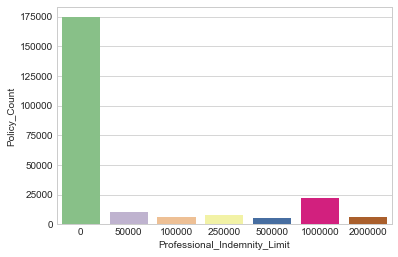

In [58]:
agg_pril['Professional_Indemnity_Limit'] = agg_pril.index

sns.barplot(x='Professional_Indemnity_Limit', y='Policy_Count',palette= 'Accent', 
             data=agg_pril)

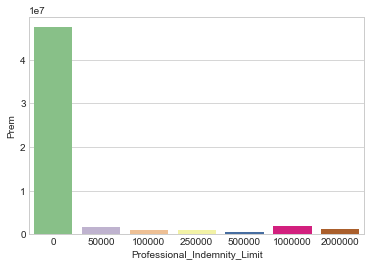

In [59]:
sns.barplot(x='Professional_Indemnity_Limit', y='Prem',palette= 'Accent', 
             data=agg_pril)

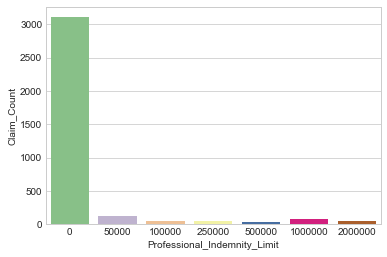

In [60]:
sns.barplot(x='Professional_Indemnity_Limit', y='Claim_Count',palette= 'Accent', 
             data=agg_pril)

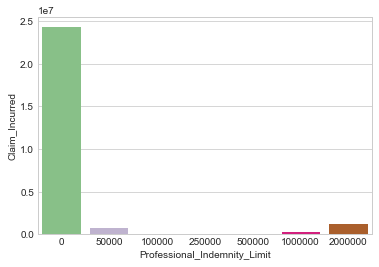

In [61]:
sns.barplot(x='Professional_Indemnity_Limit', y='Claim_Incurred',palette= 'Accent', 
             data=agg_pril)

**Inference from Employers Liability Analysis **

    1. Policies with 0 Professional Indemnity limit is the highest contributor across all KPIs
    2. For policies with 1M Professional Indemnity, has a relatively higher Policy Volume
    3. However, for policies with 2M have a higher Claim Incurred Cost


** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Trade Categories **

In [62]:
agg_trdc = pd.DataFrame(policy_data_2.groupby(['Trade_1_Category'])[['Policy_Count']].sum())
agg_trdc['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Trade_1_Category'])[['Claim_Count']].sum())
agg_trdc['Prem'] = pd.DataFrame(policy_data_2.groupby(['Trade_1_Category'])[['Gross_Premium_Excl_PI']].sum())
agg_trdc['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Trade_1_Category'])[['Claim_Incurred']].sum())

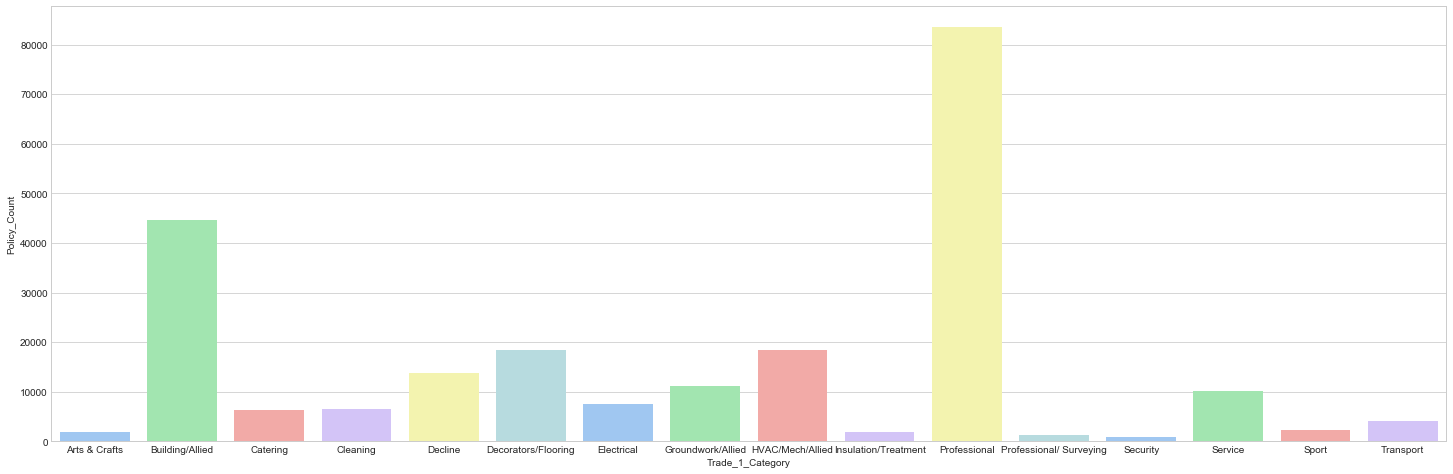

In [63]:
agg_trdc['Trade_1_Category'] = agg_trdc.index

a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Category', y='Policy_Count',palette= 'pastel', 
             data=agg_trdc)

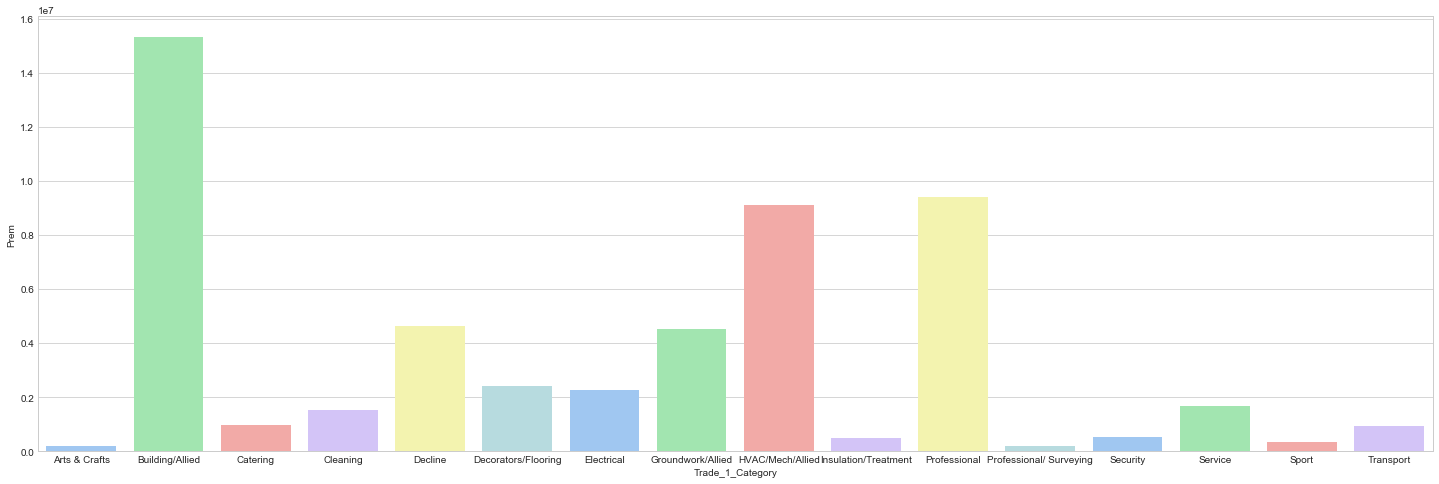

In [64]:
agg_trdc['Trade_1_Category'] = agg_trdc.index

a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Category', y='Prem',palette= 'pastel', 
             data=agg_trdc)

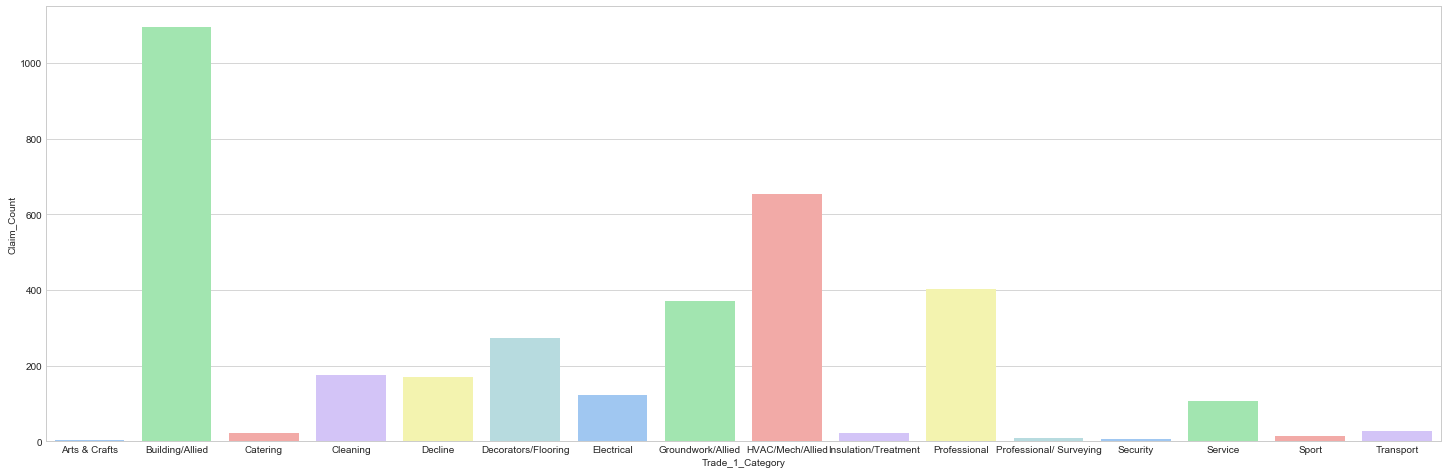

In [65]:
agg_trdc['Trade_1_Category'] = agg_trdc.index

a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Category', y='Claim_Count',palette= 'pastel', 
             data=agg_trdc)

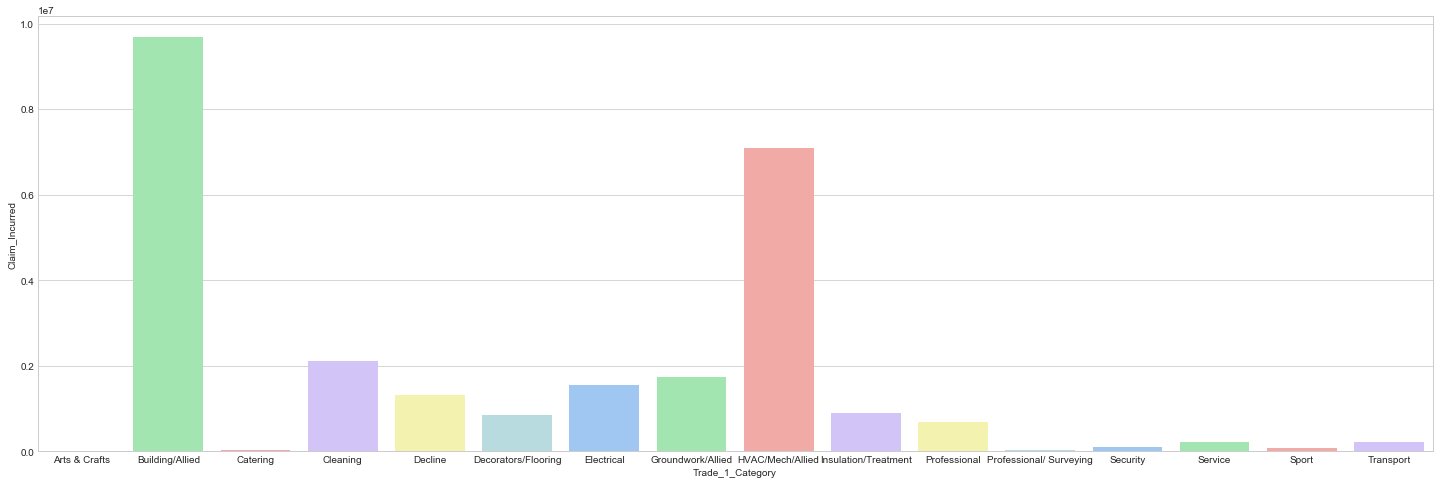

In [66]:
agg_trdc['Trade_1_Category'] = agg_trdc.index

a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Category', y='Claim_Incurred',palette= 'pastel', 
             data=agg_trdc)

**Inference from Trade Category Analysis **

    1. Majority of Policies are purchased for Professional Employees or Employees working in Building or Allied Services
    2. Even though the Polcy Volume is relatively less for HV/Mech Allied, Growund Work and Decline categories, 
       their Premium Share to the Overall GWP is comparitiely higher 
    3. Majoriy of claims are received by Building/Allied followed by Mech-Allied Wrk, Professional,and Decline categories
    4. Negligle number of claims are received for Arts & Crafts, and Catering Categories
    5. Even though the number of Claims received are higher for Professional, Incurred Cost for the same is very less
    6. Net Incurred Cost is highest for Building/Allied, followed by Mech/Allied, Cleaning and Decline categories
    

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Trade Risk Level **

In [67]:
agg_trrl = pd.DataFrame(policy_data_2.groupby(['Trade_1_Risk_Level'])[['Policy_Count']].sum())
agg_trrl['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Trade_1_Risk_Level'])[['Claim_Count']].sum())
agg_trrl['Prem'] = pd.DataFrame(policy_data_2.groupby(['Trade_1_Risk_Level'])[['Gross_Premium_Excl_PI']].sum())
agg_trrl['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Trade_1_Risk_Level'])[['Claim_Incurred']].sum())

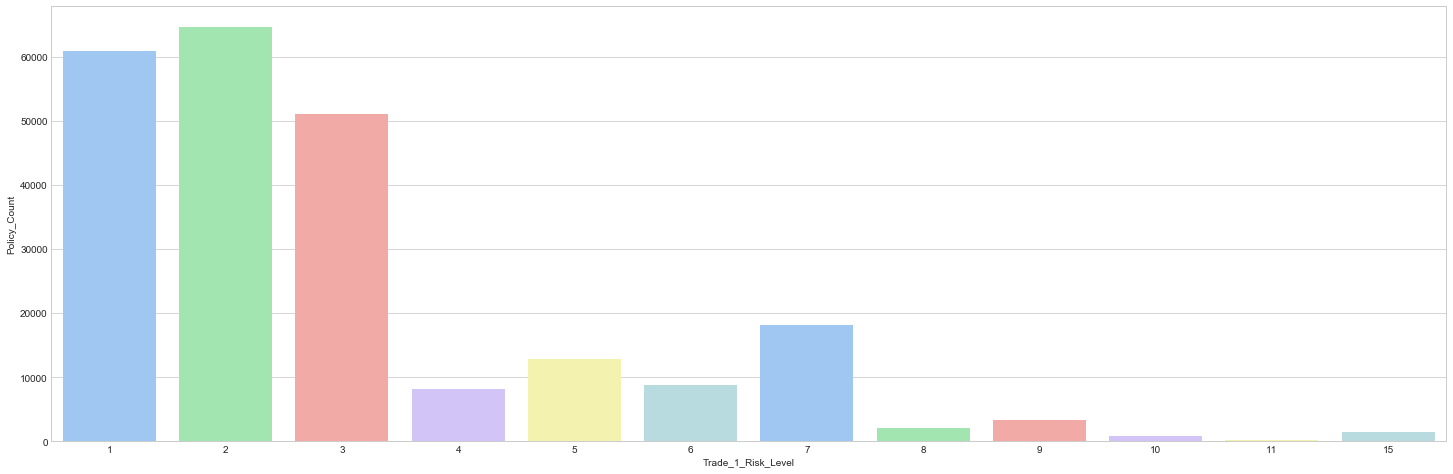

In [68]:
agg_trrl['Trade_1_Risk_Level'] = agg_trrl.index

a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Risk_Level', y='Policy_Count',palette= 'pastel', 
             data=agg_trrl)

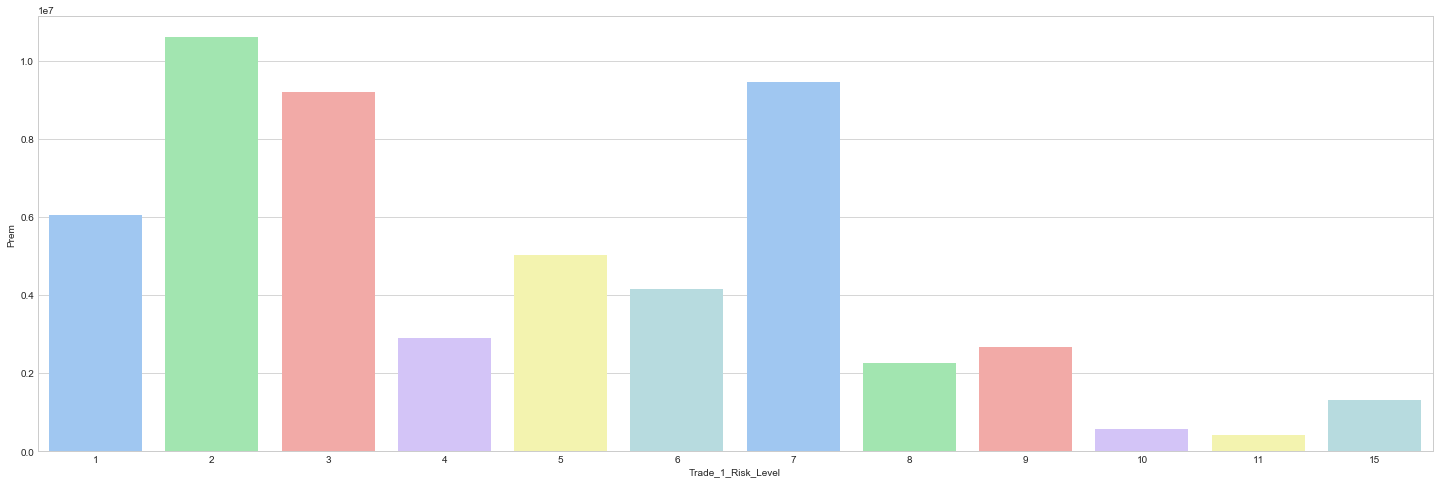

In [69]:
a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Risk_Level', y='Prem',palette= 'pastel', 
             data=agg_trrl)

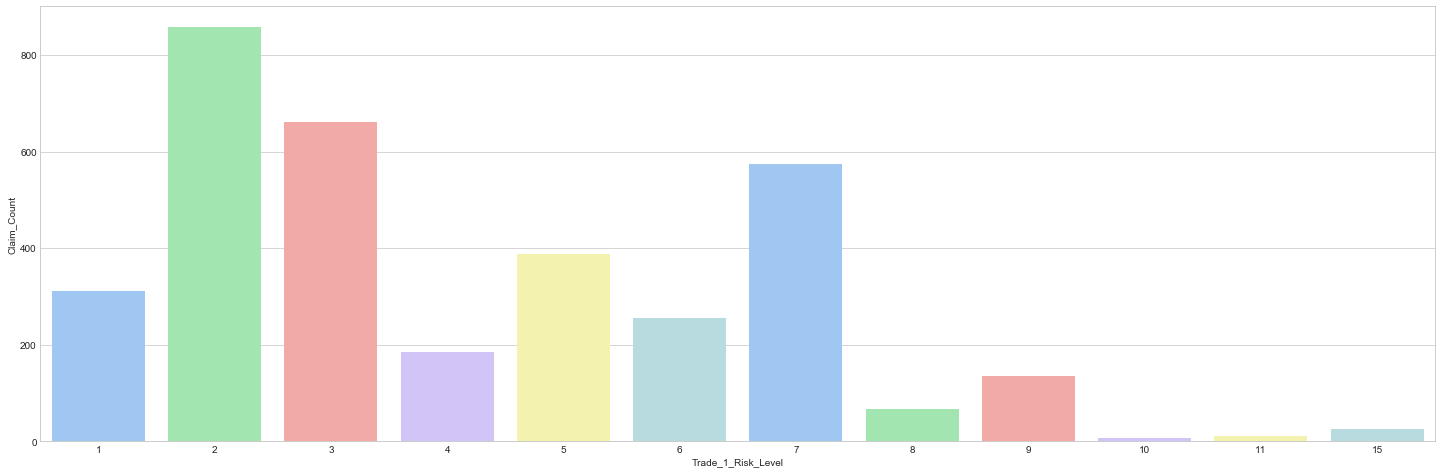

In [70]:
a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Risk_Level', y='Claim_Count',palette= 'pastel', 
             data=agg_trrl)

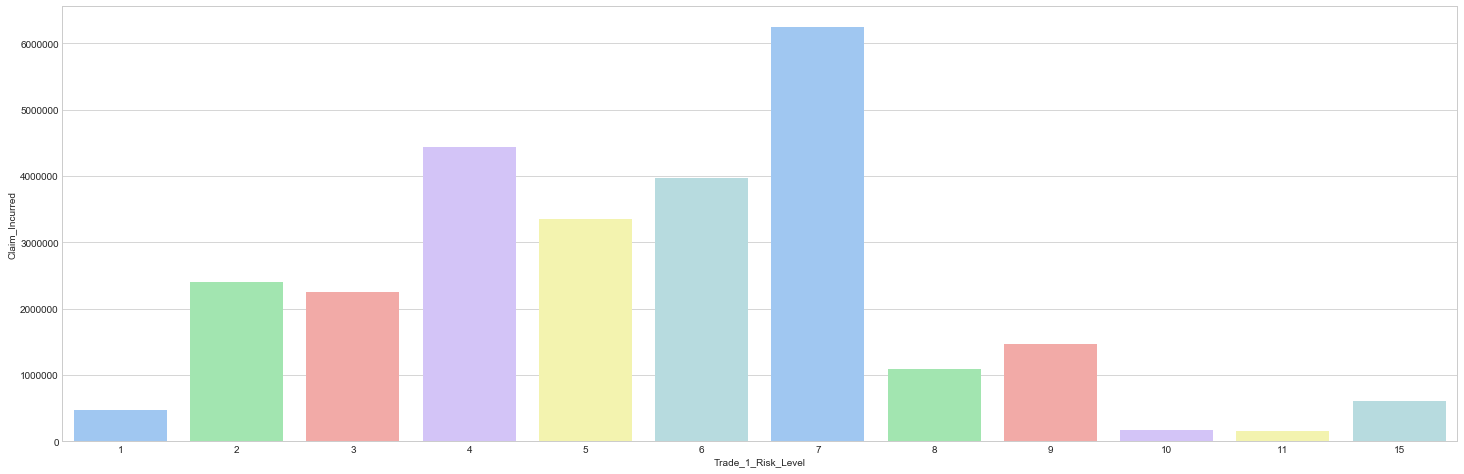

In [71]:
a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Trade_1_Risk_Level', y='Claim_Incurred',palette= 'pastel', 
             data=agg_trrl)

**Inference from Trade Risk Level Analysis **

    1. Risk Level 2 is the highest contributor for Policy Volume, followed by Level 1, 3 & 7
    2. However in terms of Premium Share, Leel 2 is the highest followed by Level 7 and 3. 
    3. Even though the number of policies is relatiely less for Levels 5 & 6, 
       their premium share is higher compared to their volume share
    4. Level 2 has the highest number of Claims received, followed by Level 3, 7, & 5
    5. However, Incurred Cost is highest for Level 7, followed by Levels 4,6 & 5

In [72]:
policy_data_2['CombinedTradeRiskLevel'].unique()

array([ 2,  3,  7,  1,  5,  6, 10,  4,  8,  9, 15, 11, 13], dtype=int64)

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Combined Trade Risk Levels **

In [73]:
agg_ctrl = pd.DataFrame(policy_data_2.groupby(['CombinedTradeRiskLevel'])[['Policy_Count']].sum())
agg_ctrl['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['CombinedTradeRiskLevel'])[['Claim_Count']].sum())
agg_ctrl['Prem'] = pd.DataFrame(policy_data_2.groupby(['CombinedTradeRiskLevel'])[['Gross_Premium_Excl_PI']].sum())
agg_ctrl['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['CombinedTradeRiskLevel'])[['Claim_Incurred']].sum())

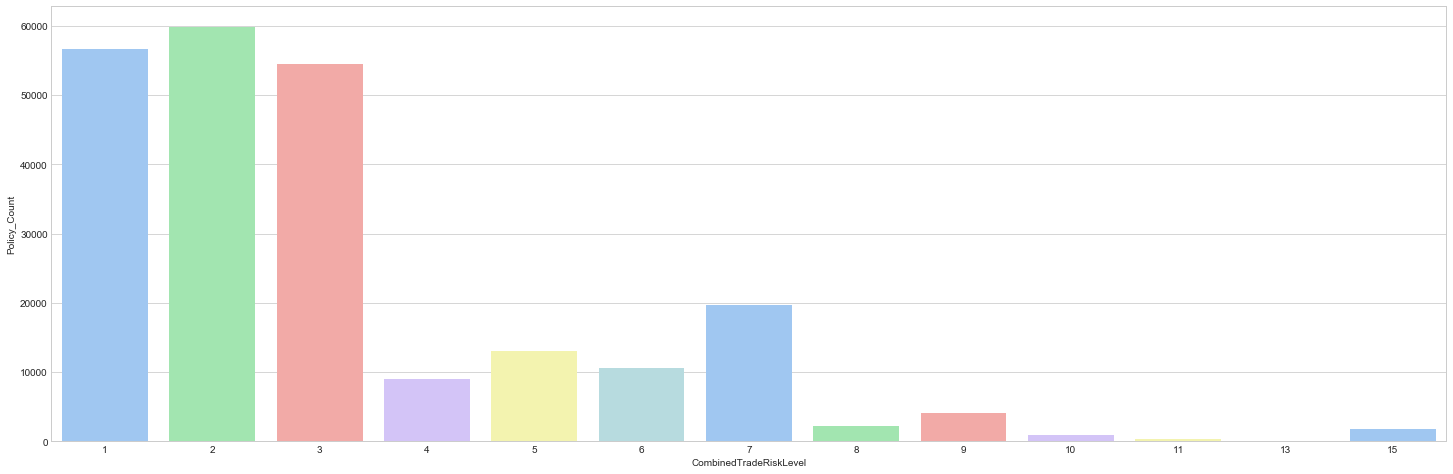

In [74]:
agg_ctrl['CombinedTradeRiskLevel'] = agg_ctrl.index

a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='CombinedTradeRiskLevel', y='Policy_Count',palette= 'pastel', 
             data=agg_ctrl)

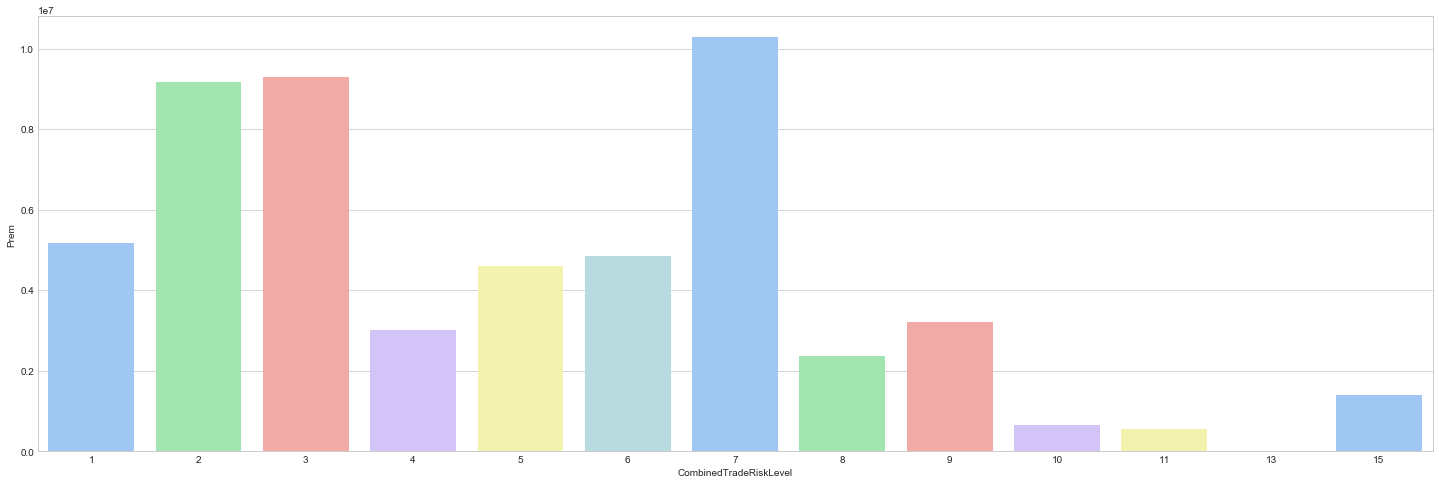

In [75]:
a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='CombinedTradeRiskLevel', y='Prem',palette= 'pastel', 
             data=agg_ctrl)

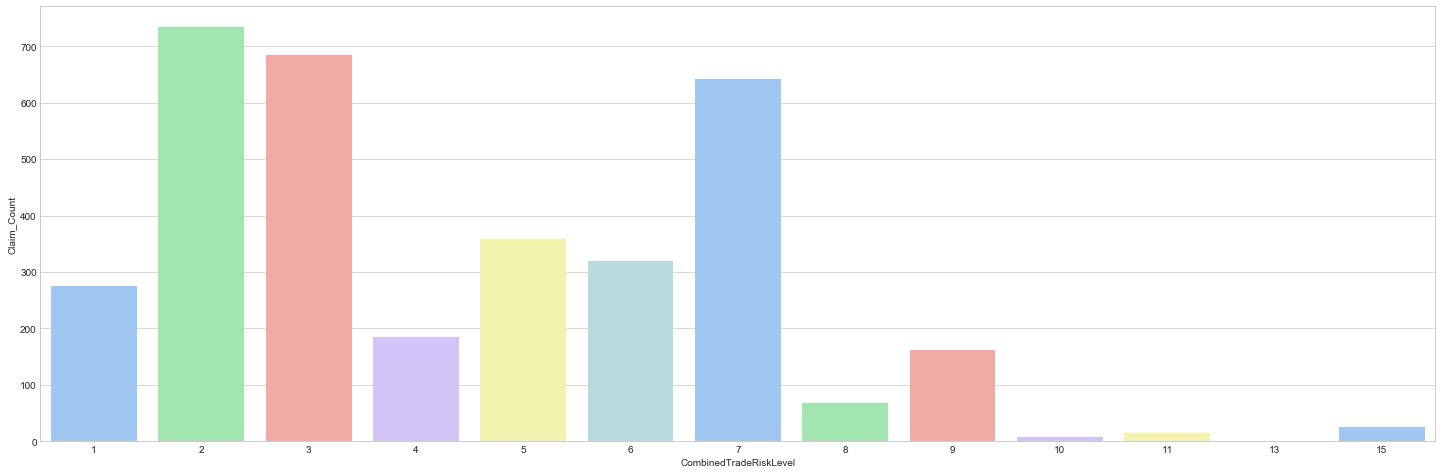

In [76]:
a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='CombinedTradeRiskLevel', y='Claim_Count',palette= 'pastel', 
             data=agg_ctrl)

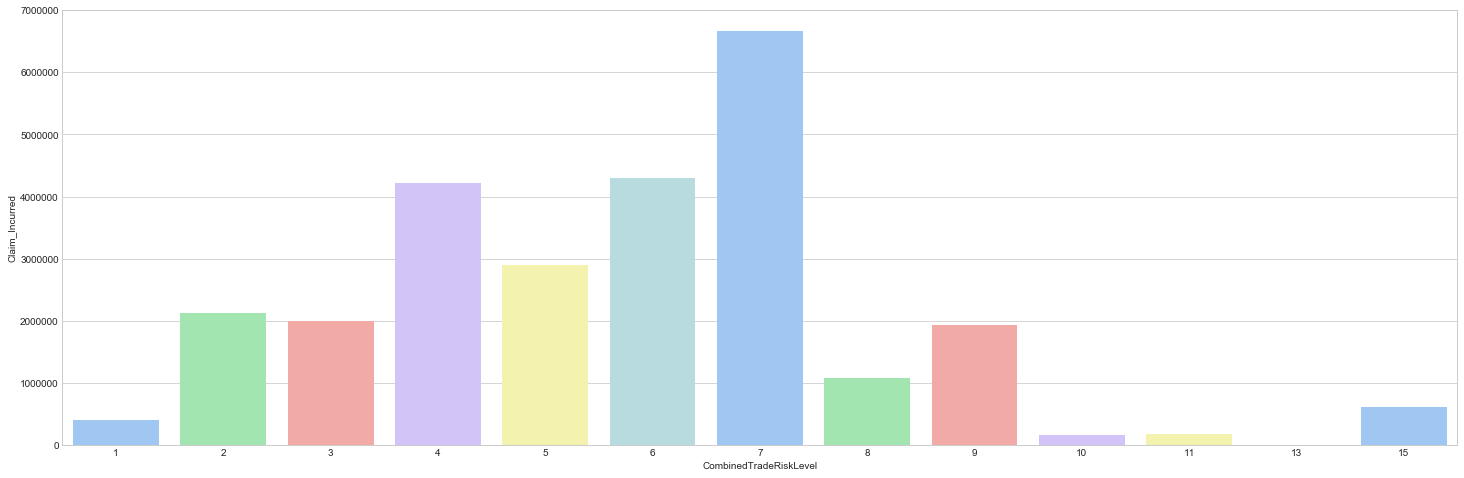

In [77]:
a4_dims = (25, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='CombinedTradeRiskLevel', y='Claim_Incurred',palette= 'pastel', 
             data=agg_ctrl)

**Inference from Trade Risk Level Analysis **

    1. Risk Level 1,2,& 3 are the Top Contributors in terms of Volume
    2. Level 7 is the highest contributor of Premium followed by Levels 3,2 & 1
    3. Even though the number of policies is relatiely less for Levels 5 & 6, 
       their premium share is higher compared to their volume share
    4. Level 2 has the highest number of Claims received, followed by Level 3, 7, & 1
    5. However, Incurred Cost is highest for Level 7, followed by Levels 4,6 & 5

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Tools Insured Index **

In [78]:
agg_tsii = pd.DataFrame(policy_data_2.groupby(['Tools_Sum_Insured_Ind'])[['Policy_Count']].sum())
agg_tsii['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Tools_Sum_Insured_Ind'])[['Claim_Count']].sum())
agg_tsii['Prem'] = pd.DataFrame(policy_data_2.groupby(['Tools_Sum_Insured_Ind'])[['Gross_Premium_Excl_PI']].sum())
agg_tsii['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Tools_Sum_Insured_Ind'])[['Claim_Incurred']].sum())

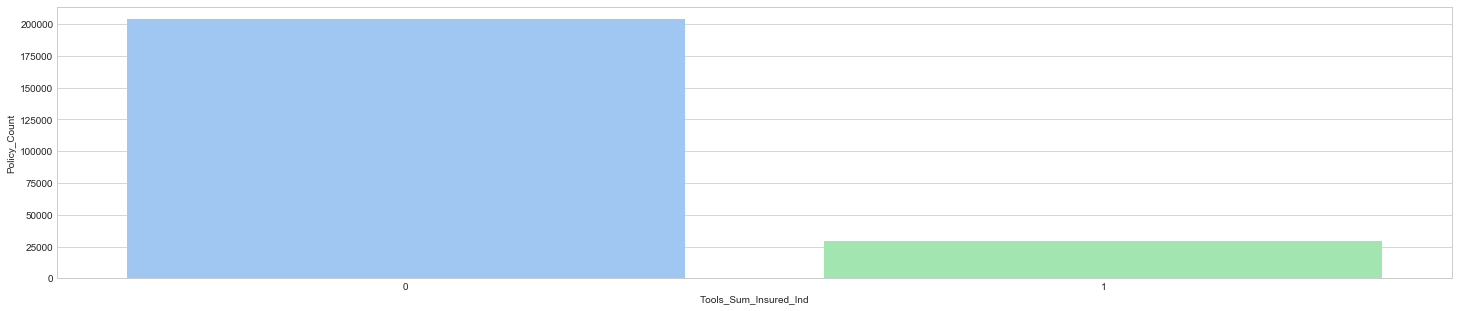

In [79]:
agg_tsii['Tools_Sum_Insured_Ind'] = agg_tsii.index

a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Tools_Sum_Insured_Ind', y='Policy_Count',palette= 'pastel', 
             data=agg_tsii)

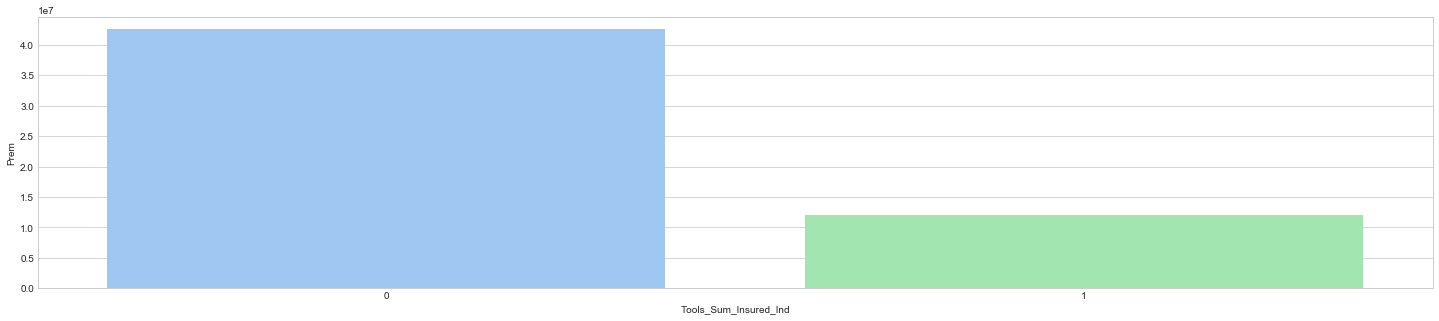

In [80]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Tools_Sum_Insured_Ind', y='Prem',palette= 'pastel', 
             data=agg_tsii)

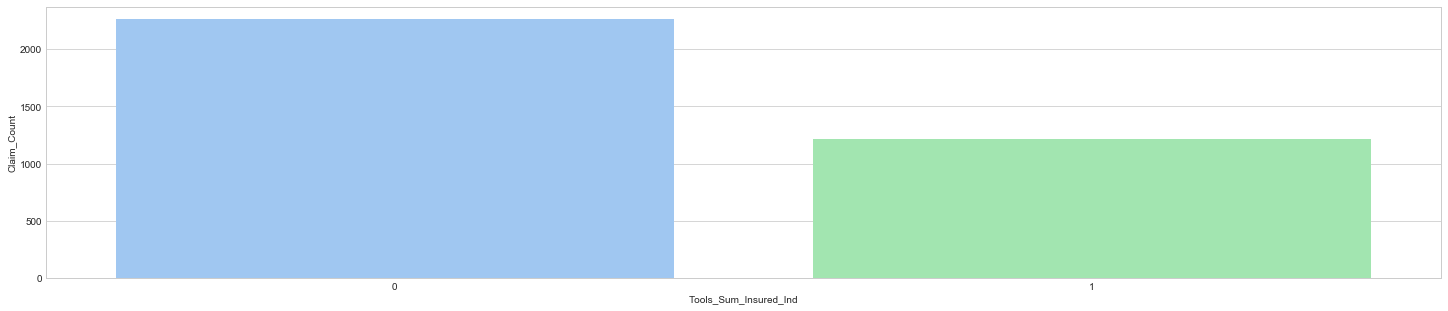

In [81]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Tools_Sum_Insured_Ind', y='Claim_Count',palette= 'pastel', 
             data=agg_tsii)

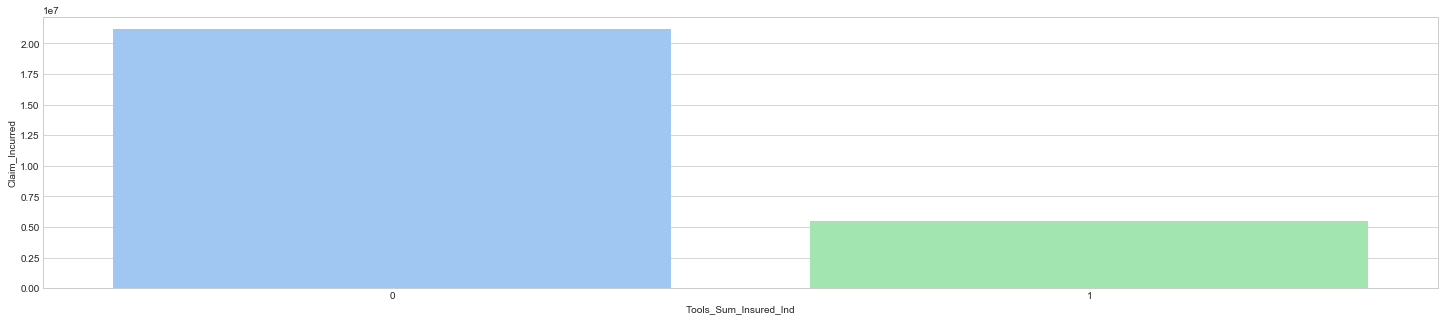

In [82]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Tools_Sum_Insured_Ind', y='Claim_Incurred',palette= 'pastel', 
             data=agg_tsii)

**Inference from Tools Sum Insured Analysis **

    1. Policies with Tools Sum NOT Insured domnates across all the KPIs
    2. However, relatively more number of claims are received for Policies with Tools Insured

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Contracts Work Insured Index **

In [83]:
policy_data_2['Contract_Works_Sum_Insured_Ind'].unique()

array([0, 1], dtype=int64)

In [84]:
agg_cwsi = pd.DataFrame(policy_data_2.groupby(['Contract_Works_Sum_Insured_Ind'])[['Policy_Count']].sum())
agg_cwsi['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Contract_Works_Sum_Insured_Ind'])[['Claim_Count']].sum())
agg_cwsi['Prem'] = pd.DataFrame(policy_data_2.groupby(['Contract_Works_Sum_Insured_Ind'])[['Gross_Premium_Excl_PI']].sum())
agg_cwsi['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Contract_Works_Sum_Insured_Ind'])[['Claim_Incurred']].sum())

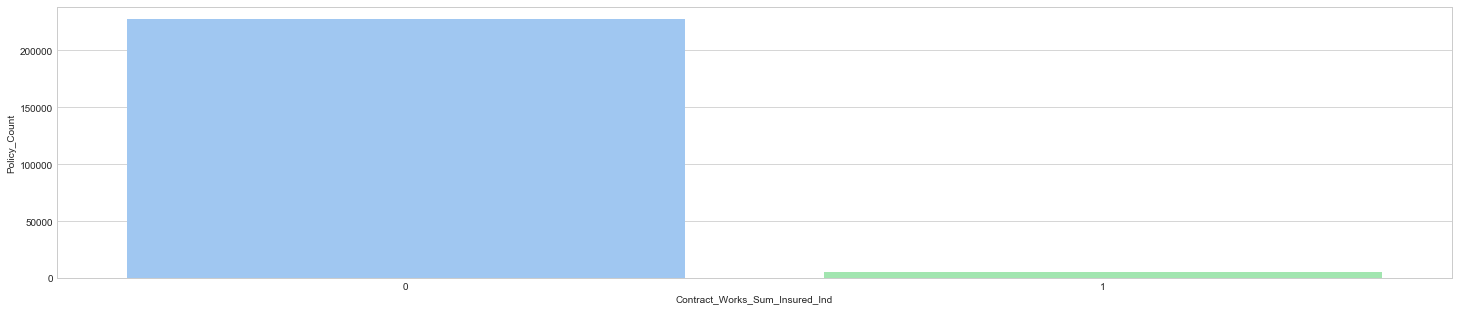

In [85]:
agg_cwsi['Contract_Works_Sum_Insured_Ind'] = agg_cwsi.index

a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Contract_Works_Sum_Insured_Ind', y='Policy_Count',palette= 'pastel', 
             data=agg_cwsi)

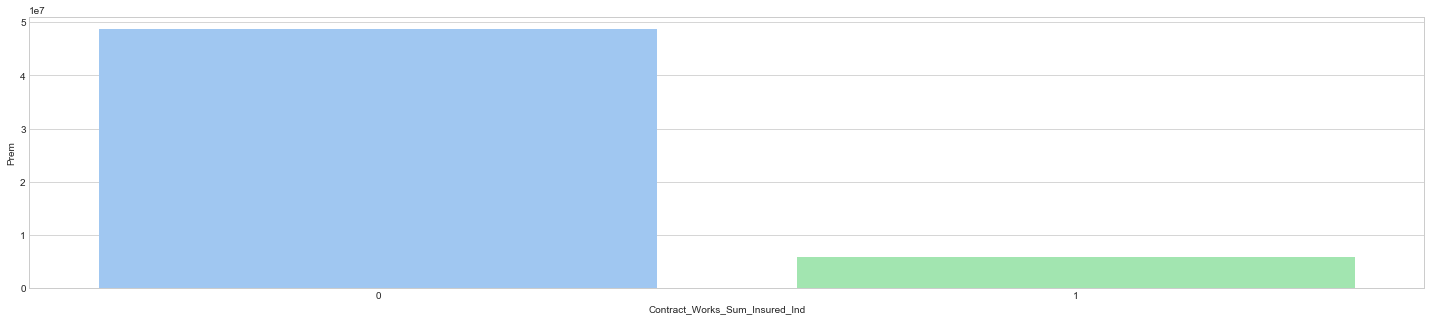

In [86]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Contract_Works_Sum_Insured_Ind', y='Prem',palette= 'pastel', 
             data=agg_cwsi)

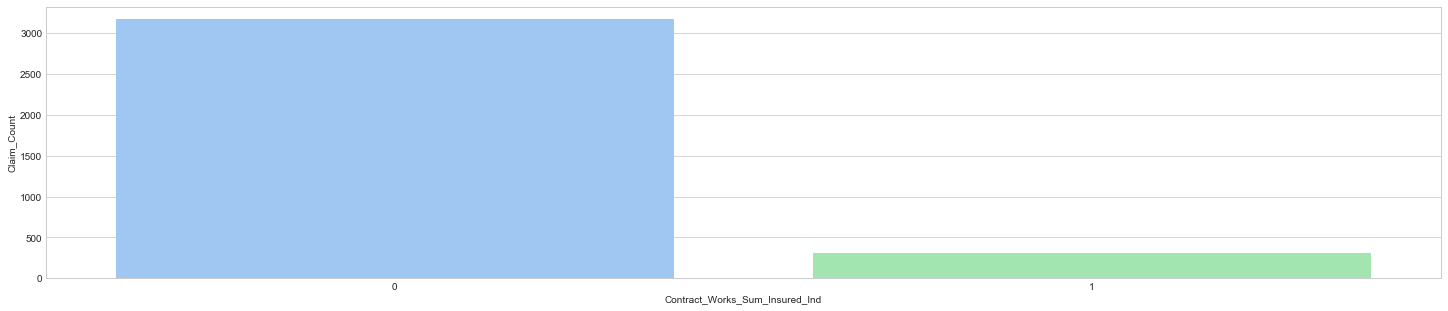

In [87]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Contract_Works_Sum_Insured_Ind', y='Claim_Count',palette= 'pastel', 
             data=agg_cwsi)

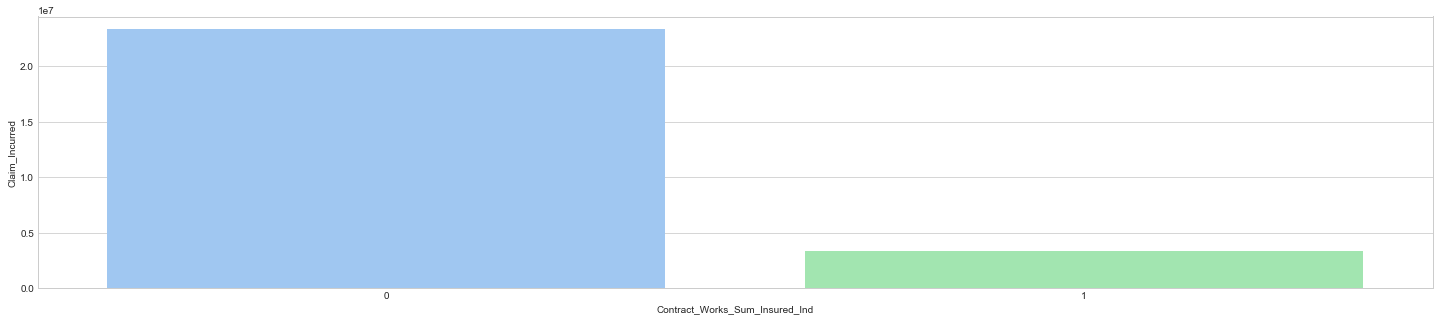

In [88]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Contract_Works_Sum_Insured_Ind', y='Claim_Incurred',palette= 'pastel', 
             data=agg_cwsi)

** Inference from Contract Works Insured **

    1. Policies with Contract Works Sum NOT Insured domnates across all the KPIs

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Hired Plan Insured Index **

In [91]:
agg_hpsi = pd.DataFrame(policy_data_2.groupby(['Hired_in_Plan_Sum_Insured_Ind'])[['Policy_Count']].sum())
agg_hpsi['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Hired_in_Plan_Sum_Insured_Ind'])[['Claim_Count']].sum())
agg_hpsi['Prem'] = pd.DataFrame(policy_data_2.groupby(['Hired_in_Plan_Sum_Insured_Ind'])[['Gross_Premium_Excl_PI']].sum())
agg_hpsi['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Hired_in_Plan_Sum_Insured_Ind'])[['Claim_Incurred']].sum())

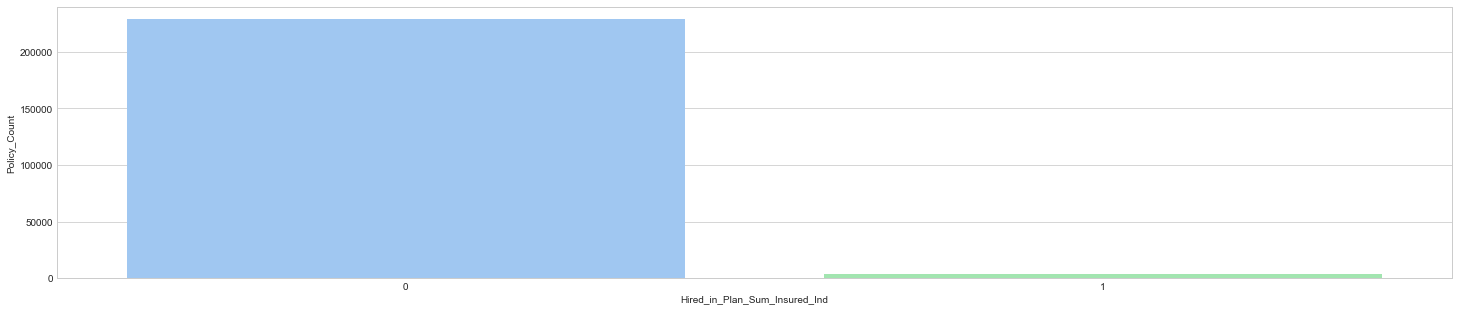

In [92]:
agg_hpsi['Hired_in_Plan_Sum_Insured_Ind'] = agg_hpsi.index

a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Hired_in_Plan_Sum_Insured_Ind', y='Policy_Count',palette= 'pastel', 
             data=agg_hpsi)

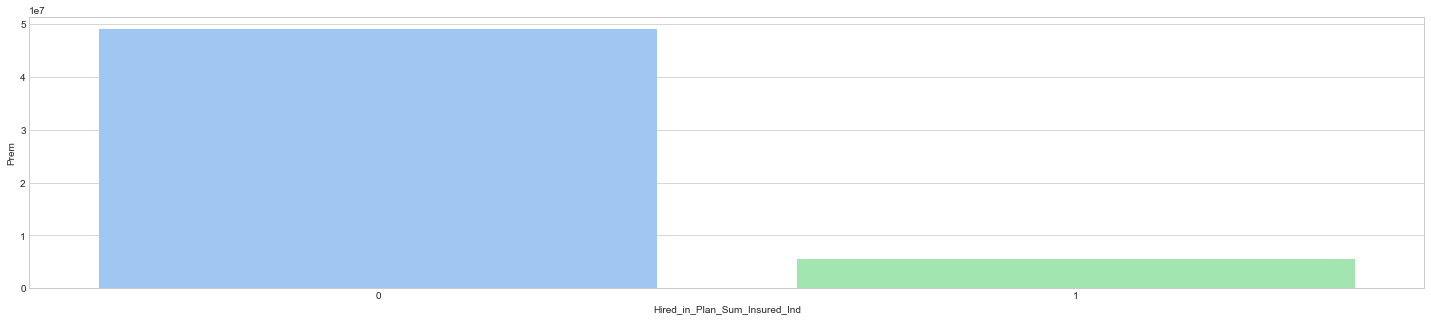

In [93]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Hired_in_Plan_Sum_Insured_Ind', y='Prem',palette= 'pastel', 
             data=agg_hpsi)

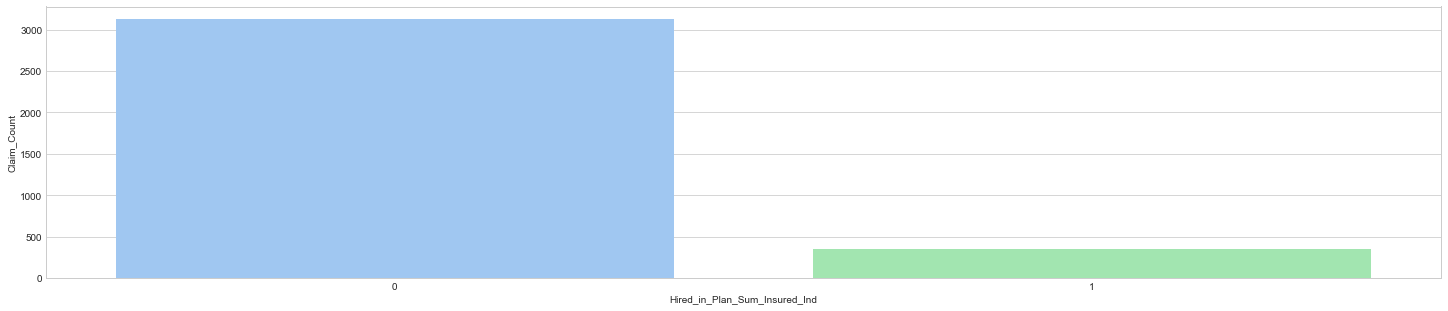

In [94]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Hired_in_Plan_Sum_Insured_Ind', y='Claim_Count',palette= 'pastel', 
             data=agg_hpsi)

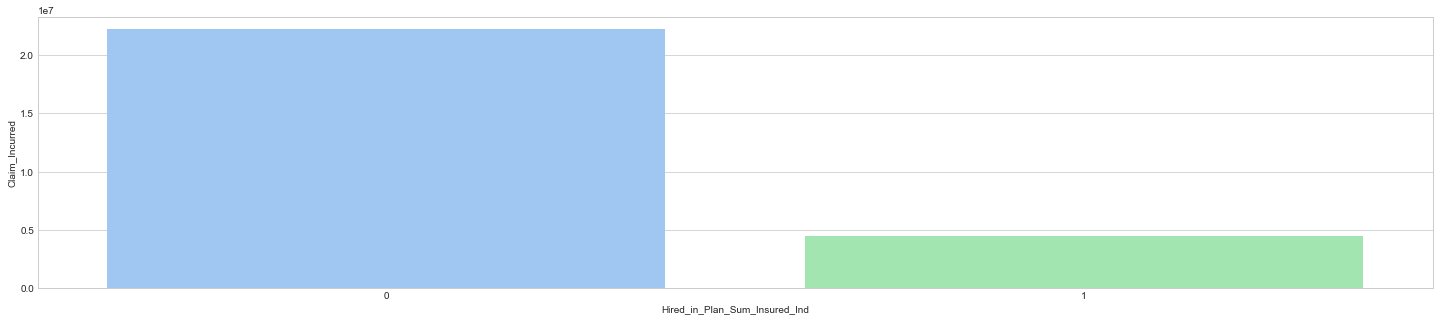

In [95]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Hired_in_Plan_Sum_Insured_Ind', y='Claim_Incurred',palette= 'pastel', 
             data=agg_hpsi)

** Inference from Contract Hired In Plan Analysis **

    1. Policies with Hired in Plan Sum NOT Insured domnates across all the KPIs

** Understand the distribuions of Policy Count, GWP, Claim Count and Incurred Cost across Own Plant Insured Index **

In [97]:
agg_opsi = pd.DataFrame(policy_data_2.groupby(['Own_Plant_Sum_Insured_Ind'])[['Policy_Count']].sum())
agg_opsi['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Own_Plant_Sum_Insured_Ind'])[['Claim_Count']].sum())
agg_opsi['Prem'] = pd.DataFrame(policy_data_2.groupby(['Own_Plant_Sum_Insured_Ind'])[['Gross_Premium_Excl_PI']].sum())
agg_opsi['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Own_Plant_Sum_Insured_Ind'])[['Claim_Incurred']].sum())

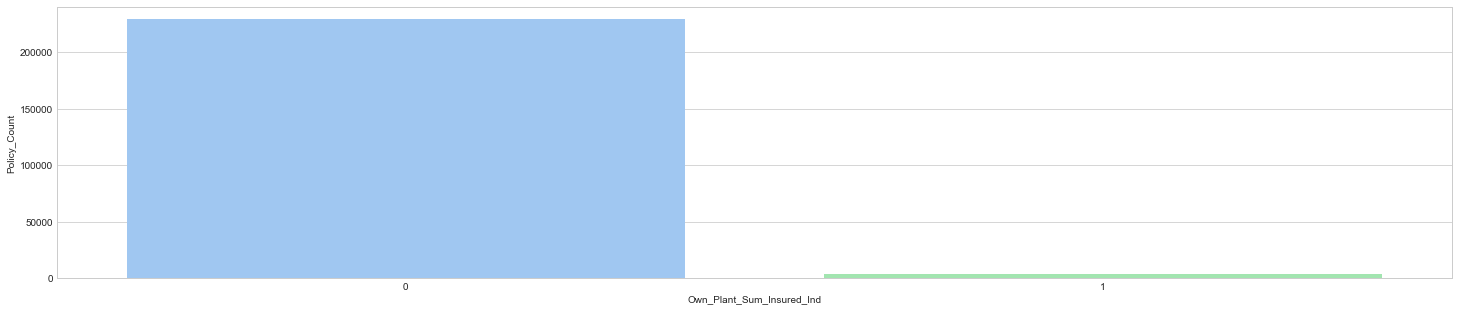

In [98]:
agg_opsi['Own_Plant_Sum_Insured_Ind'] = agg_opsi.index

a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Own_Plant_Sum_Insured_Ind', y='Policy_Count',palette= 'pastel', 
             data=agg_opsi)

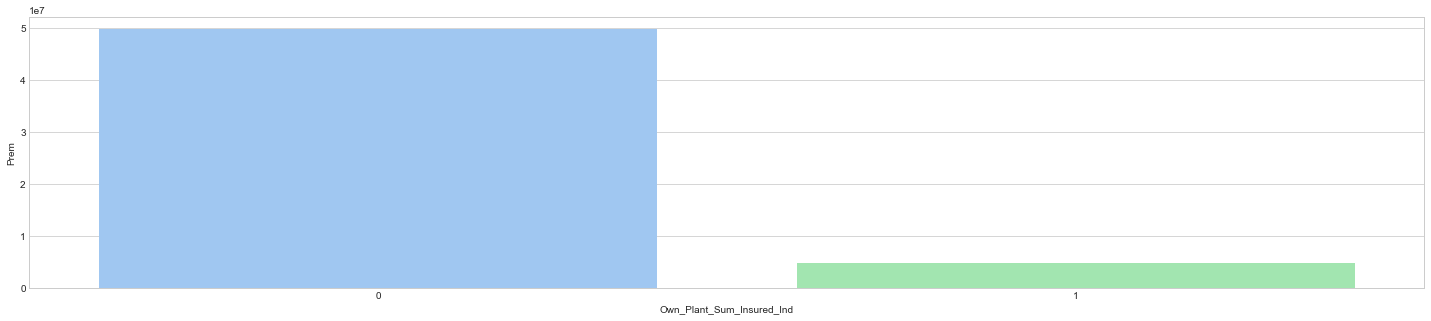

In [99]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Own_Plant_Sum_Insured_Ind', y='Prem',palette= 'pastel', 
             data=agg_opsi)

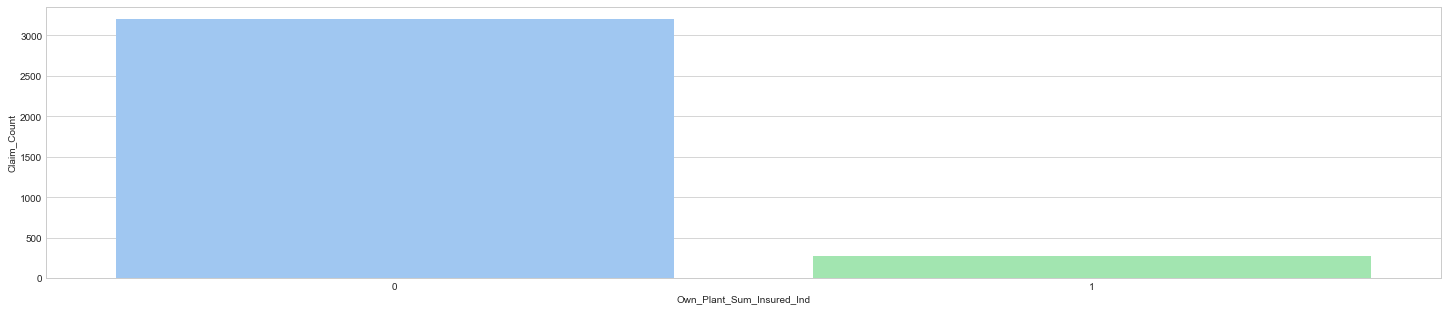

In [100]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Own_Plant_Sum_Insured_Ind', y='Claim_Count',palette= 'pastel', 
             data=agg_opsi)

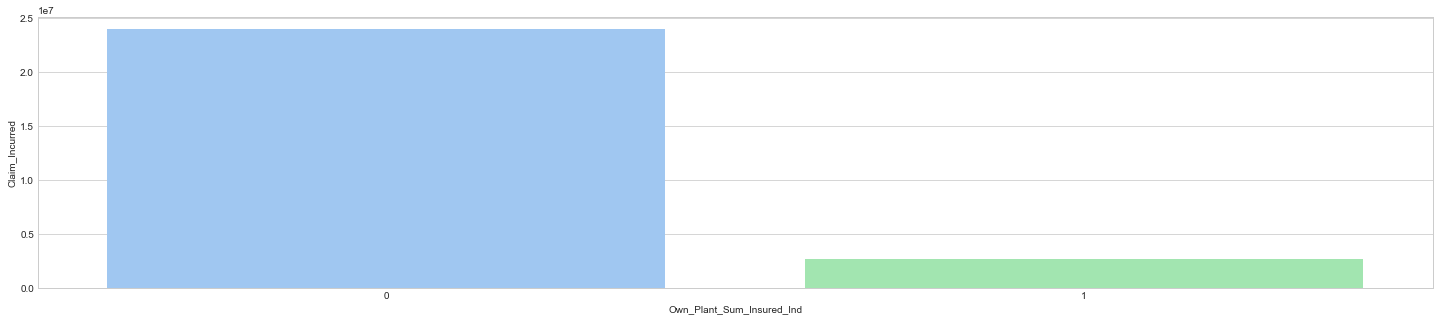

In [101]:
a4_dims = (25, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax= ax, x='Own_Plant_Sum_Insured_Ind', y='Claim_Incurred',palette= 'pastel', 
             data=agg_opsi)

** Inference from Own Plant Insured Analysis **

    1. Policies with Hired in Own Plant NOT Insured domnates across all the KPIs

** Exploratoy Data Analysis: Part II - Feature Trend Analysis **

So far, we have been focussing on the overall performance(including Policy and Claims) for each feature.

Since our objective is to predict whether a Claim will be lodged for a Policy or not, we'll try to understand the features and their trends in influencing a claim.

Hence, we'll be plotting graphs only for Claim Count and Claim Incurred

** Understand the distribuions trends of Policy Count, GWP, Claim Count and Incurred Cost across Own Product **

In [102]:
agg_yr_prod = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year','Product'])[['Policy_Count']].sum())
agg_yr_prod['Claim_Count'] = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year','Product'])[['Claim_Count']].sum())
agg_yr_prod['Prem'] = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year','Product'])[['Gross_Premium_Excl_PI']].sum())
agg_yr_prod['Claim_Incurred'] = pd.DataFrame(policy_data_2.groupby(['Underwriting_Year','Product'])[['Claim_Incurred']].sum())

In [103]:
agg_yr_prod.reset_index()

Underwriting_Year                 Product  Policy_Count  Claim_Count  \
0                2010       Tradesman Non-Dqi          3392           80   
1                2011       Tradesman Non-Dqi          6077          103   
2                2012       Tradesman Non-Dqi          8150          150   
3                2013      Finsbury Tradesman         23960          147   
4                2013       Glemham Tradesman         70475         1240   
5                2013      Maltings Tradesman            15            0   
6                2013  New Finsbury Tradesman             6            0   
7                2013       Tradesman Non-Dqi          8643          158   
8                2014      Finsbury Tradesman         15156           93   
9                2014       Glemham Tradesman         53358          925   
10               2014      Maltings Tradesman         21311          305   
11               2014  New Finsbury Tradesman         13342          101   
12               2014           Tradesman Dqi           123            4   
13               2014       Tradesman Non-Dqi          8708          169   

            Prem  Claim_Incurred  
0   1.288379e+06      1084076.38  
1   2.213618e+06       690954.21  
2   2.937213e+06      2056520.19  
3   3.353412e+06       495588.57  
4   1.607805e+07     11605522.62  
5   1.247860e+03            0.00  
6   2.714600e+02            0.00  
7   3.232566e+06      1729536.78  
8   2.115880e+06       152805.69  
9   1.337019e+07      5147534.99  
10  4.618668e+06      1095630.11  
11  1.869554e+06       122804.01  
12  7.163665e+04        44598.43  
13  3.404089e+06      2392177.42